# K-means inertia & silhouette score  

Throughout the following exercises, you will learn about the process of using inertia and silhouette score in scikit-learn to help determine a _k_ value for a K-means model on higher-dimensional data that cannot easily be visualized in 2-D or 3-D space. 

All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook. 

Focus items include:

*   Import statements
*   Scaling the data using `StandardScaler`
*   Instantiating the model
*   Fitting the model
*   KMeans `labels_` attribute
*   KMeans `inertia_` attribute
*   Using scikit-learn's `silhouette_score` function 
*   Determining a value for _k_  



As we move forward, you can find instructions on how to install required libraries as they arise in this notebook. 

## Import statements

Before we begin with the exercises and analyzing the data, we need to import all libraries and extensions required for this programming exercise. Throughout the course, we will be using numpy and pandas for operations, and seaborn for data visualization. 

Of particular note here, are the `Kmeans`, `silhouette_score`, and `StandardScaler` statements. These are the elements directly related to the K-means modeling process.

In [1]:
# IMPORT STATEMENTS

# Standard operational package imports
import numpy as np
import pandas as pd

##################################################
# Important imports for modeling and evaluation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
##################################################


# (To create synthetic data)
from sklearn.datasets import make_blobs

# Visualization package import
import seaborn as sns

## Create the data

In practice, you'd have a dataset of real data, and you'd read in this data and perform EDA, data cleaning, and other manipulations to prepare it for modeling. For simplicity and to help us focus on the modeling itself, we're going to use synthetic data for this demonstration.

We'll start by creating a random number generator. This is to help with the process of creating _reproducible_ synthetic data. We'll use it to create clustered data without us knowing how many clusters there are.

In [2]:
# Create random number generator
rng = np.random.default_rng(seed=42)

By calling the random number generator and assigning the result to a variable, we can avoid seeing the true number of clusters our data has. This keeps the "answer" a secret, and will let us use inertia and silhouette coefficients to determine it.

In [4]:
# Create synthetic data w/ unknown number of clusters
centers = rng.integers(low=3, high=7)
X, y = make_blobs(n_samples=1000, n_features=6, centers=centers, random_state=42)

The above steps that generated our synthetic data return two things: `X` and `y`. `X` is an array of the values for the synthetic data itself and `y` is an array that contains the cluster assignment for each sample in `X` (represented as an integer).

Right now we're concerned with `X`, because it is our mystery data. It's currently an array, but it's usually helpful to view your data as a pandas dataframe. This is often how your data will be organized when modeling real-world data, so we'll convert our data to a pandas df.

In [5]:
# Create Pandas dataframe from the data
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5
0,-0.202026,-4.511672,2.662548,-6.012876,-5.528781,-3.382204
1,6.929489,-3.994597,-5.991395,-5.942751,-3.968276,1.718698
2,-1.696336,9.643915,3.810884,1.412989,-6.132334,-6.269739
3,-2.441635,4.524060,-4.571437,-0.062614,3.301567,-9.149222
4,0.128557,6.221514,-5.980320,-0.018876,1.767374,-12.241417


We see that the data has 6 features (columns). This is too many for us to visualize in 2-D or 3-D space. We can't see how many clusters there are, so we'll need to use our detective skills to determine this.
<br />
<br />
## Scale the data

Since K-means uses distance between observations and centroids as its measure of similarity, it's important to scale your data before modeling, if it's not already scaled. It's important to scale because K-means doesn't know what your unit label is for each variable. Suppose you had data for penguins, and height were measured in meters and weight were measured in grams. Without scaling, significant differences in height would be represented as small numbers, while minor differences in weight would be represented as much larger numbers.

To perform scaling, we'll use scikit-learn's [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#). StandardScaler scales each point xᵢ by subtracting the mean value for that feature and dividing by the standard deviation:

x-scaled = (xᵢ – mean(x)) / σ

This ensures that, after scaling, each feature variable has a mean of 0 and variance/standard deviation of 1. There are a number of scaling techniques available, including `StandardScaler`, `MinMaxScaler`, `Normalizer`, and others, each scaling the data in a particular way. There's no hard rule for determining which method will work best, but with K-means models, using any scaler will almost always result in better results than not scaling at all. 

You can instantiate StandardScaler and transform your data in a single step by using the `.fit_transform()` method and passing to it your data as an argument.
<br />
<br />
**Tip:** If your computing environment has sufficient resources, it's helpful to keep an unscaled copy of your data to use later. Assign the scaled data to a new variable.

In [6]:
# Scale the data
X_scaled = StandardScaler().fit_transform(X)
X_scaled[:2,:]

array([[ 0.13276528, -0.82728856,  0.88064572, -1.09430592, -0.52268725,
        -0.43173911],
       [ 1.61351948, -0.74931849, -0.75143903, -1.08212993, -0.2754658 ,
         0.32266328]])

## Instantiate the model

Now that the data is scaled, we can start modeling. Since we don't know how many clusters exist in the data, we'll begin by examining the inertia values for different values of k. 

One thing to note is that, by default, scikit-learn implements an optimized version of the K-means algorithm, called K-means++. This helps to ensure optimal model convergence by initializing centroids far away from each other. Because we're using K-means++, we will not rerun the model multiple times.

We'll begin by instantiating the model. If we want to build a model that clusters the data into three clusters, we'd set the `n_clusters` parameter to 3. We'll also set the `random_state` to an arbitrary number. This is only so others can reproduce your results. If you left this value blank, it's possible others could replicate your code exactly and still get different results due to the random initial placement of centroids.

In [7]:
# Instantiate model
kmeans3 = KMeans(n_clusters=3, random_state=42)

## Fit the data

Now that we've instantiated the model, the next step is to fit it to the data. We do this by using the `.fit()` method and passing to it our scaled data.

In [8]:
# Fit model to data
kmeans3.fit(X_scaled)

F:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

This returns a model object that has "learned" your data. You can now call its different attributes to see inertia, location of centroids, and class labels, among others. See the [K-means documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) for a full list of available attributes.

We can get the cluster assignments by using the `.labels_` attribute. Similarly, we can get the inertia by using the `.inertia_` attribute. 

Let's see what happens when we check the cluster assignments and inertia for this model.

In [9]:
print('Clusters: ', kmeans3.labels_)
print('Inertia: ', kmeans3.inertia_)

Clusters:  [2 2 0 0 0 0 0 2 0 0 1 2 0 0 0 2 0 0 0 0 2 2 2 2 2 0 2 0 2 0 0 0 2 2 0 2 1
 2 1 0 0 2 0 0 2 0 0 2 0 0 1 0 2 0 0 0 0 0 1 0 2 0 0 2 2 1 2 2 2 1 2 2 0 0
 2 0 0 0 2 0 0 0 0 1 0 2 0 0 1 1 2 2 0 0 0 0 0 0 2 1 2 1 0 2 0 0 2 0 2 0 1
 0 0 0 0 2 2 2 2 1 0 0 0 0 1 1 2 0 0 2 2 0 2 0 2 2 2 0 0 1 1 2 0 2 2 0 1 0
 1 0 2 1 0 2 0 0 0 2 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 2 0 1 2 0 0 1 2 2 2
 1 0 2 2 1 0 1 0 1 2 0 2 0 0 1 1 2 0 0 0 0 1 2 2 0 2 0 2 0 2 2 0 0 2 1 2 0
 0 2 2 0 1 0 0 2 2 0 0 0 0 2 1 0 2 2 1 1 0 0 1 0 0 0 2 2 1 0 1 0 0 0 0 2 1
 0 0 0 0 1 1 0 0 0 0 2 2 0 0 1 0 2 0 0 2 2 2 0 2 2 0 2 0 0 1 2 0 0 1 2 0 2
 1 1 1 2 0 1 0 0 0 0 0 2 1 0 2 0 2 0 1 0 2 0 0 0 2 0 2 2 1 0 2 0 1 1 2 0 1
 1 0 1 2 1 0 0 2 0 2 2 0 1 1 2 1 2 0 0 0 0 0 0 1 2 2 0 0 1 0 0 1 2 0 0 0 2
 1 0 2 2 0 0 0 0 2 0 0 0 0 2 0 0 1 0 0 2 1 0 0 0 1 2 2 2 0 0 0 0 0 1 2 1 0
 0 1 2 1 0 1 2 2 0 0 0 0 0 0 2 0 2 2 0 2 1 2 0 1 2 2 0 0 1 2 2 2 0 2 2 1 2
 2 0 2 1 2 1 2 0 0 0 2 2 1 0 0 2 0 0 2 0 0 0 2 0 0 2 0 0 2 1 1 1 1 0 2 2 2
 2 1 0 0 1 2 0

The `.labels_` attribute returns a list of values that is the same length as the training data. Each value corresponds to the number of the cluster to which that point is assigned. Since our K-means model clustered the data into three clusters, the value assigned to each observation will be 0, 1, or 2. (Note that the cluster number itself is arbitrary, and serves only as a label.)  
<br/>

The `.inertia_` attribute returns the sum of the squared distances of samples from their closest cluster center.


## Evaluate inertia

This inertia value isn't helpful by itself. We need to compare the inertias of multiple _k_ values. To do this, we'll create a function that fits a K-means model for multiple values of _k_, calculates the inertia for each _k_ value, and appends it to a list.

In [10]:
# Create a list from 2-10. 
num_clusters = [i for i in range(2, 11)]

def kmeans_inertia(num_clusters, x_vals):
    '''
    Fits a KMeans model for different values of k.
    Calculates an inertia score for each k value.

    Args:
        num_clusters: (list of ints)  - The different k values to try
        x_vals:       (array)         - The training data

    Returns: 
        inertia:      (list)          - A list of inertia scores, one for each \
                                      value of k
    '''

    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)
    
    return inertia

In [11]:
# Calculate inertia for k=2-10
inertia = kmeans_inertia(num_clusters, X_scaled)
inertia

F:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
F:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
F:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
F:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

[3810.4594427747534,
 2419.03771486472,
 1355.2307702502542,
 661.4184399859329,
 176.1940356194409,
 171.12340095186818,
 165.1198751010013,
 160.16278049929912,
 157.8415008239691]

### Elbow plot

Now we can plot these values in a simple line graph, with the _k_ values along the x-axis and inertia on the y-axis. This type of plot is called an elbow plot. The "elbow" is usually the part of the curve with the sharpest angle, where the reduction in inertia that occurs when a new cluster is added begins to level off. 

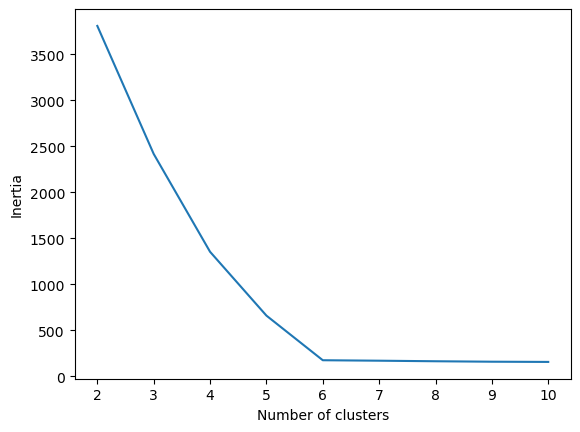

In [12]:
# Create an elbow plot
plot = sns.lineplot(x=num_clusters, y=inertia)
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Inertia");

This plot contains an unambiguous elbow at five clusters. Models with more than five clusters don't seem to reduce inertia much at all. Right now, it seems like a 5-cluster model might be optimal. 

Let's now check silhouette scores. Hopefully the results will corroborate our findings from the assessment of inertia.



## Evaluate silhouette score

Unlike inertia, silhouette score doesn't have its own attribute that can be called on the model object. To get a silhouette score, we have to use the `silhouette_score()` function that we imported from `sklearn.metrics`. You must pass to it two required parameters: your training data and their assigned cluster labels. Let's see what this looks like for the `kmeans3` model we created earlier.

In [13]:
# Get silhouette score for kmeans3 model
kmeans3_sil_score = silhouette_score(X_scaled, kmeans3.labels_)
kmeans3_sil_score

0.4917105089773743

It worked! However, this value isn't very useful if we have nothing to compare it to. Just as we did for inertia, we'll write a function that compares the silhouette score of each value of _k_, from 2 through 10.

In [14]:
def kmeans_sil(num_clusters, x_vals):
    '''
    Fits a KMeans model for different values of k.
    Calculates a silhouette score for each k value

    Args:
        num_clusters: (list of ints)  - The different k values to try
        x_vals:       (array)         - The training data

    Returns: 
        sil_score:    (list)          - A list of silhouette scores, one for each \
                                      value of k
    '''
  
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        sil_score.append(silhouette_score(x_vals, kms.labels_))
    
    return sil_score

In [15]:
# Calculate silhouette scores for k=2-10
sil_score = kmeans_sil(num_clusters, X_scaled)
sil_score

F:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
F:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
F:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
F:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

[0.39709919404713834,
 0.4917105089773743,
 0.5921096273196574,
 0.6962954474662842,
 0.7905315537903802,
 0.6844966467269864,
 0.5845937965343314,
 0.48451721872250764,
 0.4789548102106697]

We can plot the silhouette score for each value of _k_, just as we did for inertia. However, remember that for silhouette score, greater numbers (closest to 1) are better, so we hope to see at least one clear "peak" that is close to 1.

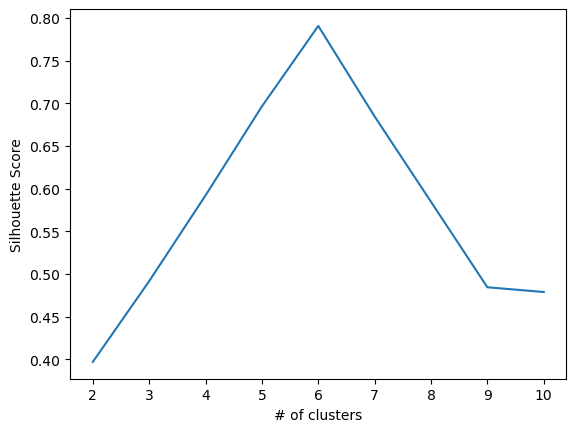

In [16]:
# Create a line plot of silhouette scores 
plot = sns.lineplot(x=num_clusters, y=sil_score)
plot.set_xlabel("# of clusters");
plot.set_ylabel("Silhouette Score");

This plot indicates that the silhouette score is closest to 1 when our data is partitioned into five clusters. It confirms what we saw in the inertia analysis, where we noticed an elbow where _k_=5. 

## Conclusion

At this point, between our inertia and silhouette score analyses, we can say with a reasonable degree of confidence that it makes the most sense to group our data into five clusters. 
<br/>  
Since we used synthetic data for this activity, we can cheat and check to see how many clusters _actually_ existed in our data. We can do this by calling the `centers` variable, which we created with the random number generator at the beginning of this notebook.

In [17]:
# Verify our findings (only possible when "correct" number of clusters exists)
centers

6

We were right! Just as we predicted, there are indeed five distinct clusters in our data. We were able to deduce this by using inertia and silhouette score!

## Further analysis

Although we know that five clusters is the best grouping for the data, the work is far from done. At this point, we'll instantiate a new K-means model with `n_clusters=5` and fit it to our data. (Note that if we had saved all the models that we fit above for different values of _k_, we wouldn't need to refit a model now, we could just call that model from earlier. But since it wasn't saved, we must fit another model.)

In [18]:
# Fit a 5-cluster model to the data
kmeans5 = KMeans(n_clusters=5, random_state=42)
kmeans5.fit(X_scaled)

F:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_clusters=5, random_state=42)

In [19]:
print(kmeans5.labels_[:5])
print('Unique labels:', np.unique(kmeans5.labels_))

[2 2 0 3 3]
Unique labels: [0 1 2 3 4]


Now that we have our labels, it's important to understand what they mean and decide whether this clustering makes sense for our use case. Here's where it helps to keep our unscaled data from the beginning. We can assign a new column to the original _unscaled_ dataframe with the cluster assignment from the final K-means model.

In [20]:
# Create new column that indicates cluster assignment in original dataframe 
X['cluster'] = kmeans5.labels_
X.head()

,0,1,2,3,4,5,cluster
0,-0.202026,-4.511672,2.662548,-6.012876,-5.528781,-3.382204,2
1,6.929489,-3.994597,-5.991395,-5.942751,-3.968276,1.718698,2
2,-1.696336,9.643915,3.810884,1.412989,-6.132334,-6.269739,0
3,-2.441635,4.524060,-4.571437,-0.062614,3.301567,-9.149222,3
4,0.128557,6.221514,-5.980320,-0.018876,1.767374,-12.241417,3


Now, we can perform analyses on the different clusters to see what makes them different from one another. The reason we'd look at cluster assignments with the unscaled data is because it's easier to relate to the unit measures. This is often a useful technique for analyzing your data, but it may also make sense to look at your cluster assignments on the scaled data, depending on your use case.  

Note that in many cases, it's not always clear what differentiates one cluster from another, and it takes a lot of work to determine whether or not it makes sense to cluster your data a given way. This is where expertise and domain knowledge are very valuable.
<br/>  
Congratulations! You now know about two very important tools to help you evaluate your K-means models, and you know how to implement them in scikit-learn. Soon, you'll apply these skills to real-world data. As always, feel free to refer back to this notebook as you continue learning.

# Bonus content

## Predicting on new data

This is not applicable to all clustering tasks, but it's now possible to take in new data and predict a cluster assignment using our final model.

To demonstrate this, we'll need a new observation, one that was not contained in our original data. We can create this with the random number generator that we used at the beginning of the notebook. 

In [21]:
# Create a new observation (for demonstration)
new_observation = rng.uniform(low=-10, high=10, size=6).reshape(1, -1)
new_observation

array([[-1.2224312 ,  7.1719584 ,  3.94736058, -8.11645304,  9.51244703,
         5.22279404]])

Just as before, we must scale this new data the same way we did earlier. This means that we need to subtract the mean _of the training data_ and divide by the standard deviation _of the training data_. If you forgot to scale here you'd get invalid results, because your model would be trained on scaled data while the new data going into it would be unscaled.

Here, we must reinstantiate a scaler and fit it to the original data, because we didn't save the scaler object itself when we performed scaling above. We fit and transformed the data in a single line of code, without saving the fit scaler object. 

Above, if instead of:  
`X_scaled = StandardScaler().fit_transform(X)`  

we had written:  
`scaler = StandardScaler()fit.(X)`  
`X_scaled = scaler.transform(X)`

then we could have reused `scaler` in this next step without having to assign it.

In [22]:
# Instantiate the scaler and fit it to the original X data
scaler = StandardScaler().fit(X.iloc[:,:-1])

# Apply the scaler to the new observation
new_observation_scaled = scaler.transform(new_observation)
new_observation_scaled

array([[-0.07910695,  0.93449469,  1.12295414, -1.45955434,  1.86020433,
         0.84090475]])

We can use the `.predict()` method of our `kmeans5` model to predict a cluster assignment by passing to it the new observation. In this case, we only have a single observation, but it's also possible to pass an array of new data as an argument, and it would return an array of cluster predictions.

In [23]:
# Predict cluster assignment of new_observation
new_prediction = kmeans5.predict(new_observation_scaled)
new_prediction

array([2])

The model has assigned this new observation to cluster 4. 

## Calculating the distance to each centroid

The KMeans model also lets us access the distances of observations from _each_ centroid. For new data, we can do this using the `.transform_` method of the fit model object.

In [24]:
# Calculate distances between new data and each centroid
distances = kmeans5.transform(new_observation_scaled)
distances

array([[3.63378865, 4.40464558, 3.28222096, 3.43171134, 4.0933285 ]])

Notice that the `.transform_` method returns an array. In this case, we gave the model a single new data point, and it returned an array of five numbers (because our model has five clusters). Each value in the array represents the distance between `new_observation_scaled` and the centroid of the cluster at that index. 

So, the distance between `new_observation_scaled` and the centroids of:

Cluster 0 = 5.12  
Cluster 1 = 4.55  
Cluster 2 = 4.15  
Cluster 3 = 5.96  
Cluster 4 = 3.47  

The shortest distance is 3.47—between `new_observation_scaled` and cluster 4's centroid. This is why the point was assigned to cluster 4 when we used the `.predict()` method above.





## Why is this useful?

One situation for which being able to assign new points to clusters is useful is when you have a deployed model that was trained on huge amounts of data, and it must process new data as it comes in on a case-by-case basis. For example, suppose you have a marketing program that sends out different promotional emails to different customers, depending on their engagement patterns with your brand. When you get a new customer, you could use a clustering model to assign them to an appropriate marketing campaign, so they see promotions that are most appropriate for them.

Also, both the cluster predictions and the distance measurements to centroids can be used as new features in supervised learning models. You can take the training data of a supervised learning problem and cluster it, then use either the cluster assignments or the distance matrices as engineered predictive features to improve the predictive power of a supervised learning model. 